# European Weather Temperature Prediction

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
import pickle
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler

## Import necessary API
import sys
sys.path.append('../../../../')
from api.v2.util.data_load import data_load
from api.v2.model.PatchMixer import PatchMixer
from api.v2.util.compare_graph import compare_graph
from types import SimpleNamespace

## Import libraries for the model
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Base Parameter Setting
* Set parameters based on the information identified during EDA (Exploratory Data Analysis).

In [2]:
# Set European Weather Data Parameter

# Set MachBase Neo URL address
URL = 'http://127.0.0.1:5654'
# Set Tag Table Name
table = 'eu_weather'
# Select Tag Name -> Can Check Tag Names Using command 'show_column(URL, table)'
# Set Austria Tag Name 
tags = ['AT_temperature']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)
# Set Tag Name
name = quote(tags_, safe=":/")
# Set resample Option -> D(day), H(hour), T(minute), S(second)
resample_freq = None
# Set Start time
start_time = '1980-01-01 00:00:00'
# Set End time 
end_time = '2019-12-31 23:00:00'
# Set TimeFormat - > 'default' or quote('2006-01-02 15:04:05.000000')(Divided down to the nanosecond)
timeformat = 'default'

## European Weather Data Load

In [3]:
# European Weather Data Load
df = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)

In [4]:
df

NAME,AT_temperature
TIME,
1980-01-01 09:00:00,-3.640
1980-01-01 10:00:00,-3.803
1980-01-01 11:00:00,-3.969
1980-01-01 12:00:00,-4.076
1980-01-01 13:00:00,-4.248
...,...
2019-12-31 19:00:00,4.719
2019-12-31 20:00:00,5.219
2019-12-31 21:00:00,5.060


In [5]:
# Split the data into train, test sets
train = df[df.index < '2019-12-01']
test = df[df.index > '2019-12-01']

## Data Preprocessing
* 1 Min-Max Scaling

### 1. Applying Min-Max Scaling

In [6]:
# Set up Scalers
scaler = MinMaxScaler()

# Apply Scalers
train_ = scaler.fit_transform(train.values)
test_ = scaler.transform(test.values)

# Set Each DataFrames
train_scaled = pd.DataFrame(train_, columns=['AT_temperature'])  
test_scaled = pd.DataFrame(test_, columns=['AT_temperature'])

# Save Scaler
with open('./result/PatchMixer_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

## Dataset & Loader Setup
- This function creates sliding windows of historical data for input and corresponding future values for forecast based on the specified window size and forecast size.

In [7]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [8]:
# Sliding window configuration
# Window size: How many past data points will be used
# Forecast: How many future data points to forcast
window_size = 5
forecast_size= 1

# Set up datasets 
train_x, train_y = time_slide_df(train_scaled, window_size, forecast_size)
test_x, test_y = time_slide_df(test_scaled, window_size, forecast_size)

train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle=False)
test_dataloader = DataLoader(test_ds,  batch_size = 64, shuffle=False)

## Model Configuration
* Using PatchMixer model.

In [9]:
# Parameter configuration
configs = SimpleNamespace(
    enc_in=1,  # Number of input features (e.g., number of features in time-series data)
    seq_len=5,  # Input sequence length (e.g., number of timesteps)
    pred_len=1,  # Prediction length (e.g., number of timesteps to predict)
    patch_len=3,  # Patch length (sub-sequence length)
    stride=1,  # Patch stride (distance between patches)
    mixer_kernel_size=3,  # Kernel size of the patch mixer layer
    
    # Model hyperparameters
    d_model=128,  # Model dimension (hidden state size)
    dropout=0.1,  # Dropout rate
    head_dropout=0.1,  # Dropout rate for multi-head attention
    e_layers=2,  # Number of layers in the model
)

In [10]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Model configuration
model = PatchMixer(configs).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

PatchMixer(
  (model): Backbone(
    (PatchMixer_blocks): ModuleList(
      (0-1): 2 x PatchMixerLayer(
        (Resnet): Sequential(
          (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, groups=4)
          (1): GELU(approximate='none')
          (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv_1x1): Sequential(
          (0): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
          (1): GELU(approximate='none')
          (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (padding_patch_layer): ReplicationPad1d((0, 1))
    (W_P): Linear(in_features=3, out_features=128, bias=True)
    (head0): Sequential(
      (0): Flatten(start_dim=-2, end_dim=-1)
      (1): Linear(in_features=512, out_features=1, bias=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (head1): Sequential(
      (0): Flatten(start_dim=-2, end_dim=-1)
      (1): Linear(in_featur

## Model Training

* Save the model with the Best Loss based on the validation data during training.

In [11]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        data = data.to(device).float()
        target = target.to(device).float()
        
        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(data)

        # Calculate loss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/European Weather_Full.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.00018782597433440775
Model saved

train loss: 0.00017741569268165346
Model saved

train loss: 0.0001731557005908623
Model saved

train loss: 0.00016954303118422594
Model saved

train loss: 0.00016706459095724982
Model saved

train loss: 0.00016498343646748794
Model saved

train loss: 0.00016345759620386375
Model saved

train loss: 0.00016235630028995805
Model saved

train loss: 0.00016140805175014273
Model saved

train loss: 0.00016063719415597297
Model saved

train loss: 0.0001599163392676024
Model saved

train loss: 0.00015929450246144608
Model saved

train loss: 0.00015873539573678976
Model saved

train loss: 0.000158338362642963
Model saved

train loss: 0.0001578304668074057
Model saved

train loss: 0.00015760122525340038
Model saved

train loss: 0.00015726352794537694
Model saved

train loss: 0.000156980158976114
Model saved

train loss: 0.00015672956102381357
Model saved

train loss: 0.00015652780818389478
Model saved

train loss: 0.00015636678417478865
Model saved

## Model Testing

In [16]:
# Load the best model
model_ = torch.load(f'./result/European Weather_Full.pt')

In [17]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    
    for batch_idx, (data, target) in enumerate(test_dataloader):
        
        data_t = data.to(device).float()
        target_t = target.to(device).float()

        outputs_t = model_(data_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[:,:1].cpu()
last_values_pred = combined_tensor_pred[:,:1].cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [18]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 0.11132391
R² Score: 0.9902080737182476


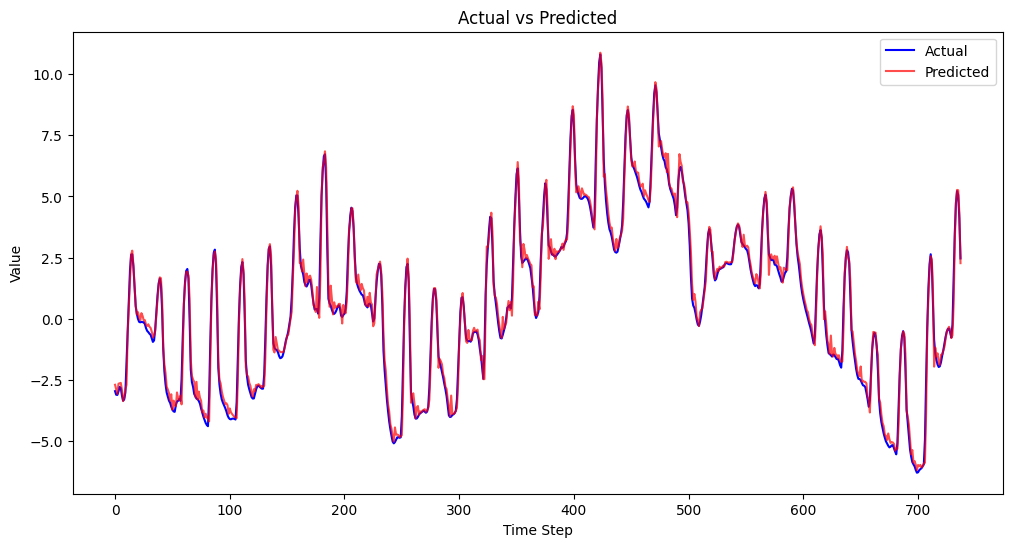

In [19]:
# Compare the test results: Actual values vs Predicted values

# Plot width
x_size=12
# Plot height
y_size=6
# Print Compare_graph
compare_graph(real_values, real_pred_values, x_size, y_size)